In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
try:
    output_filepath
except:
    output_filepath = 's3://workspaces-clarity-mgmt-pro/jaime.oliver/misc/social_capital/data/processed_3/'

In [3]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import numpy.linalg as la
from scipy import stats

from utils import data_loader

import patsy
import statsmodels.api as sm
from linearmodels import PanelOLS
from linearmodels import RandomEffects
from linearmodels.panel import PooledOLS, compare

from linearmodels import IV2SLS
from arellano_bond import PanelLaggedDep

import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 22})
plt.rcParams['savefig.facecolor']='white'

label_dict = {'financial_hubs': r'$\mu_\mathcal{F}$',
             'financial_authorities': r'$\nu_\mathcal{F}$',
             'goods_hubs': r'$\mu_\mathcal{G}$',
             'goods_authorities': r'$\nu_\mathcal{G}$',
             'human_hubs': r'$\mu_\mathcal{M}$',
             'human_in_favor':r'$\xi_\mathcal{M}$',
             'log_GFCF':r'$\alpha$',
             'log_wkn_population':r'$\beta$',}


In [4]:
reduced_terms_list, df_model = data_loader(output_filepath)

In [5]:
corr_cols = ['log_output', 'log_gdp', 'gini', 'log_GFCF', 'log_wkn_population'] + reduced_terms_list

df_model[['country', 'year'] + corr_cols].describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
country,693,63,DNK,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,693,NaN,NaN,NaN,2010,3.16456,2005,2007,2010,2013,2015
log_output,693,NaN,NaN,NaN,13.1611,1.63172,9.2651,12.1621,13.1661,14.2926,17.2437
log_gdp,693,NaN,NaN,NaN,12.4528,1.64519,8.68912,11.4061,12.4565,13.6032,16.6869
gini,300,NaN,NaN,NaN,0.319593,0.0604838,0.234,0.26975,0.315,0.349,0.62
log_GFCF,693,NaN,NaN,NaN,24.8718,1.68266,20.8034,23.8554,24.8415,26.0618,29.1997
log_wkn_population,693,NaN,NaN,NaN,15.8962,1.75242,11.9892,14.8156,15.9243,17.0253,20.4807
financial_hubs,693,NaN,NaN,NaN,14.0345,0.533541,12.8298,13.6625,13.9762,14.3717,16.4159
financial_authorities,693,NaN,NaN,NaN,13.913,0.673574,12.4945,13.4146,13.8139,14.2712,16.6493
goods_hubs,693,NaN,NaN,NaN,13.9914,0.581539,12.8074,13.5855,13.9208,14.3369,16.4432


In [6]:
df_model[df_model.human_authorities==0].country.unique()

array(['ARG', 'BGR', 'BRA', 'BRN', 'CHN', 'COL', 'CRI', 'CYP', 'GRC',
       'HKG', 'HRV', 'IDN', 'IND', 'KAZ', 'KHM', 'LTU', 'LVA', 'MAR',
       'MEX', 'MLT', 'MYS', 'PER', 'PHL', 'ROU', 'RUS', 'SAU', 'SGP',
       'SVN', 'THA', 'TUN', 'TUR', 'VNM', 'ZAF'], dtype=object)

In [7]:
df_model[df_model.human_hubs==0].country.unique()

array([], dtype=object)

In [8]:
df_model[df_model.country=='CHN'][reduced_terms_list]

,financial_hubs,financial_authorities,goods_hubs,goods_authorities,human_hubs,human_in_favor
110,15.741413,15.900838,15.893807,16.109750,10.459310,0.0
111,15.758731,15.932065,15.942842,16.168162,10.519286,0.0
112,15.936520,16.115380,16.069881,16.297330,10.561069,0.0
113,15.830541,16.030055,15.971710,16.211834,10.634884,0.0
114,16.073717,16.244415,16.213950,16.439427,10.463358,0.0
115,15.737808,15.942927,15.966331,16.236018,10.596128,0.0
116,15.834802,16.055632,16.021103,16.316276,10.709914,0.0
117,16.041660,16.263486,16.158419,16.441254,10.711218,0.0
118,16.170880,16.394460,16.251120,16.537591,10.586186,0.0
119,16.286490,16.517779,16.298905,16.588011,10.468450,0.0


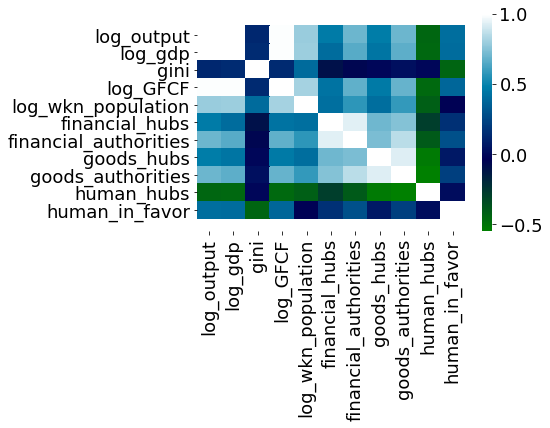

In [9]:
plt.rcParams.update({'font.size': 18})

corr = df_model[corr_cols].corr()

# plot the heatmap
sns.heatmap(corr, cmap="ocean",
        xticklabels=corr.columns,
        yticklabels=corr.columns,)

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.7 # Add 0.5 to the bottom
t -= 0.7 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!

In [10]:
from scipy.stats import pearsonr
import statsmodels.api as sm

def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""

    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = '\u03C1'
    ax.annotate(f'{rho} = {r:.2f}', xy=(.5, .1), xycoords=ax.transAxes)

def r2func(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""

    x = sm.add_constant(x)
    model = sm.OLS(y,x)
    results = model.fit()
    r2 = results.rsquared

    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    ax.annotate(f'$R^2$= {r2:.2f}', xy=(.5, .1), xycoords=ax.transAxes)

In [11]:
'''
plt.rcParams.update({'font.size': 10})

variables = ['log_gdp', 'log_GFCF', 'log_wkn_population'] + reduced_terms_list
names = ['$\log(GDP)$', '$\log(K)$', '$\log(L)$',
         'Financial \n $I_{it}^{out}$', 'Financial \n $I_{it}^{in}$',
         'G&S \n $I_{it}^{out}$', 'G&S \n $I_{it}^{in}$',
         'Migration  \n $I_{it}^{out}$', 'Migration  \n $I_{it}^{in}$', 'Migration  \n $F_{it}$']

g = sns.pairplot(df_model[variables].sample(500), 
                 kind='reg', 
                 diag_kind = 'kde', 
                 plot_kws={'scatter_kws': {'alpha': 0.03}, 
                 'line_kws':{'color':'red'}})
g.fig.set_size_inches(12,12)

g.map_upper(r2func)
plt.rcParams.update({'font.size': 10})
g.map_lower(corrfunc)

names_dict = dict(zip(variables, names))

plt.rcParams.update({'font.size': 16})
for i in range(len(variables)):
    for j in range(len(variables)):
        xlabel = g.axes[i][j].get_xlabel()
        ylabel = g.axes[i][j].get_ylabel()
        if xlabel in names_dict.keys():
            g.axes[i][j].set_xlabel(names_dict[xlabel])
        if ylabel in names_dict.keys():
            g.axes[i][j].set_ylabel(names_dict[ylabel])

plt.tight_layout()
save_to = os.path.join(Path(os.getcwd()).parent.resolve(), 'reports', 'figures', f'social_capital_multicolinearity.png')
plt.savefig(save_to)    
plt.show()
'''

"\nplt.rcParams.update({'font.size': 10})\n\nvariables = ['log_gdp', 'log_GFCF', 'log_wkn_population'] + reduced_terms_list\nnames = ['$\\log(GDP)$', '$\\log(K)$', '$\\log(L)$',\n         'Financial \n $I_{it}^{out}$', 'Financial \n $I_{it}^{in}$',\n         'G&S \n $I_{it}^{out}$', 'G&S \n $I_{it}^{in}$',\n         'Migration  \n $I_{it}^{out}$', 'Migration  \n $I_{it}^{in}$', 'Migration  \n $F_{it}$']\n\ng = sns.pairplot(df_model[variables].sample(500), \n                 kind='reg', \n                 diag_kind = 'kde', \n                 plot_kws={'scatter_kws': {'alpha': 0.03}, \n                 'line_kws':{'color':'red'}})\ng.fig.set_size_inches(12,12)\n\ng.map_upper(r2func)\nplt.rcParams.update({'font.size': 10})\ng.map_lower(corrfunc)\n\nnames_dict = dict(zip(variables, names))\n\nplt.rcParams.update({'font.size': 16})\nfor i in range(len(variables)):\n    for j in range(len(variables)):\n        xlabel = g.axes[i][j].get_xlabel()\n        ylabel = g.axes[i][j].get_ylabel()\n 

## FULL MODEL COMPARISON

In [12]:
def adj_rsquared(model):
    adj_rsquared = 1 - (model.nobs-1)/model.df_resid * (1-model.rsquared)
    return adj_rsquared

In [13]:
reduced_terms_regression = ' + '.join(reduced_terms_list)

df_index = df_model.set_index(['country', 'year'])

# Base model
f = f'log_gdp ~ log_GFCF + log_wkn_population + 1'
y, X = patsy.dmatrices(f, df_index,  return_type='dataframe')
base_model = PooledOLS(y,X)
base_model_hac = base_model.fit(cov_type="kernel")
base_model = base_model.fit()

f = f'log_gdp ~ log_GFCF + log_wkn_population + 1'
y, X = patsy.dmatrices(f, df_index,  return_type='dataframe')
base_model_re = RandomEffects(y,X)
base_model_re_hac = base_model_re.fit(cov_type="kernel")
base_model_re = base_model_re.fit()

f = f'log_gdp ~ log_GFCF + log_wkn_population + 1'
y, X = patsy.dmatrices(f, df_index,  return_type='dataframe')
base_model_fe = PanelOLS(y,X, entity_effects=True, time_effects=True)
base_model_fe_hac = base_model_fe.fit(cov_type="kernel")
base_model_fe = base_model_fe.fit()

# Extended model
f = f'log_gdp ~ {reduced_terms_regression} +  log_GFCF + log_wkn_population + 1'
y, X = patsy.dmatrices(f, df_index,  return_type='dataframe')
extended_model = PooledOLS(y,X)
extended_model_hac = extended_model.fit(cov_type="kernel")
extended_model = extended_model.fit()

f = f'log_gdp ~ {reduced_terms_regression} +  log_GFCF + log_wkn_population + 1'
y, X = patsy.dmatrices(f, df_index,  return_type='dataframe')
extended_model_re = RandomEffects(y,X)
extended_model_re_hac = extended_model_re.fit(cov_type="kernel")
extended_model_re = extended_model_re.fit()

f = f'log_gdp ~ {reduced_terms_regression} + log_GFCF + log_wkn_population + 1'
y, X = patsy.dmatrices(f, df_index,  return_type='dataframe')
extended_model_fe = PanelOLS(y,X, entity_effects=True, time_effects=True)
extended_model_fe_hac = extended_model_fe.fit(cov_type="kernel")
extended_model_fe = extended_model_fe.fit()

ab_model = PanelLaggedDep(endog = df_index['log_gdp'],
                       exogs = df_index[reduced_terms_list], 
                       systemGMM = False,
                       iv_max_lags=1,
                       lags=1,
                       add_intercept=False,
                       entity_effects=False,
                       weight_type='clustered')

#ab_model = ab_model.fit()

model_dict = {#'Base Model':base_model,
              'Base Mode HAC':base_model_hac,
              #'Extended Model':extended_model,
              'Extended Model HAC':extended_model_hac,
              #'Base Model Random Effects':base_model_re,
              'Base Model Random Effects HAC':base_model_re_hac,
              #'Base Model Fixed Effects':base_model_fe,
              #'Base Model Fixed Effects HAC':base_model_fe_hac,
              #'Extended Model Random Effects':extended_model_re,
              'Extended Model Random Effects HAC':extended_model_re_hac,
              #'Extended Model Fixed Effects':extended_model_fe,
              #'Extended Model Fixed Effects HAC':extended_model_fe_hac,
             }

c = compare(model_dict, precision='std_errors', stars=True, )
#print(c.summary.as_latex())
c.summary

/repos/social_capital_in_trade_networks/notebooks/arellano_bond.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dropped['CLUSTER_VAR'] = dropped.index.get_level_values(0)


,Base Mode HAC,Extended Model HAC,Base Model Random Effects HAC,Extended Model Random Effects HAC
Dep. Variable,log_gdp,log_gdp,log_gdp,log_gdp
Estimator,PooledOLS,PooledOLS,RandomEffects,RandomEffects
No. Observations,693,693,693,693
Cov. Est.,Driscoll-Kraay,Driscoll-Kraay,Driscoll-Kraay,Driscoll-Kraay
R-squared,0.9815,0.9838,0.8894,0.9043
R-Squared (Within),0.5791,0.6639,0.7201,0.7576
R-Squared (Between),0.9891,0.9899,0.9690,0.9809
R-Squared (Overall),0.9815,0.9838,0.9644,0.9767
F-statistic,1.826e+04,5185.9,2775.5,807.98
P-value (F-stat),0.0000,0.0000,0.0000,0.0000


In [14]:
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan, het_goldfeldquandt


df_extra = pd.DataFrame({'Model':[k for k,v in model_dict.items()],
                         'Adj-r2':[adj_rsquared(v) for k,v in model_dict.items()],
                         'nobs':[v.nobs for k,v in model_dict.items()],
                         'DW':[durbin_watson(v.resids) for k,v in model_dict.items()],
                         'BP':[het_breuschpagan(v.resids, v.model.exog.dataframe.values)[1] for k,v in model_dict.items()],
                         'GQ':[het_goldfeldquandt(v.resids, v.model.exog.dataframe.values)[1] for k,v in model_dict.items()]})
df_extra

,Model,Adj-r2,nobs,DW,BP,GQ
0,Base Mode HAC,0.981407,693,0.393317,3.447650e-03,0.999910
1,Extended Model HAC,0.983591,693,0.369965,2.372858e-09,0.967195
2,Base Model Random Effects HAC,0.889120,693,0.591422,1.336564e-14,0.999994
3,Extended Model Random Effects HAC,0.903187,693,0.618936,1.200972e-17,0.999974


In [15]:
def hausman(fe, re):
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov
    df = b[np.abs(b) < 1.e8].size
    chi2 = np.dot((b - B).T, la.inv(v_b - v_B).dot(b - B)) 

    pval = stats.chi2.sf(chi2, df)
    return chi2, df, pval

hausman_results = hausman(extended_model_fe_hac, extended_model_re_hac) 
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: -1260.0343223853572
degrees of freedom: 9
p-Value: 1.0


Pvalue < 0.05 we reject the null that random effects are consistent.

## VIF

In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(df_model[['log_GFCF', 'log_wkn_population'] + reduced_terms_list].values, i) for i in range(len(reduced_terms_list )+2)]

print(list(zip(['log_GFCF', 'log_wkn_population'] + reduced_terms_list, vif)))

[('log_GFCF', 1408.1187113062638), ('log_wkn_population', 439.70866150264953), ('financial_hubs', 16816.90050489222), ('financial_authorities', 20133.348693167605), ('goods_hubs', 12974.591581721535), ('goods_authorities', 16121.799294238283), ('human_hubs', 156.04227460107325), ('human_in_favor', 4.475312024839437)]


## PCA variables

Text(0, 0.5, 'cumulative explained variance')

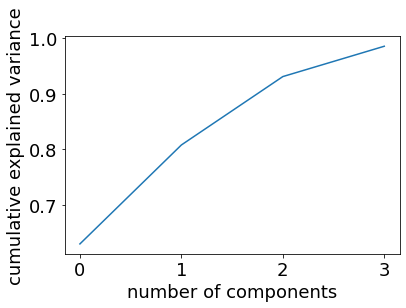

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

n = 4

pipe = Pipeline([
        ('scale', StandardScaler()),
        ('reduce_dims', PCA(n_components=n))]
        )

df_model[[f'pca_{i}' for i in range(n)]] = pipe.fit_transform(df_model[reduced_terms_list])

pipe = Pipeline([
        ('scale', StandardScaler()),
        ('reduce_dims', PCA(n_components=n))]
        )
pipe.fit(df_model[reduced_terms_list])

plt.plot(np.cumsum(pipe['reduce_dims'].explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [18]:
df_index = df_model.set_index(['country', 'year'])
pca_terms = [f'pca_{i}' for i in range(n)]
pca_terms_regression = ' + '.join(pca_terms)

# Base model
f = f'log_gdp ~ log_GFCF + log_wkn_population + 1'
y, X = patsy.dmatrices(f, df_index,  return_type='dataframe')
base_model = PooledOLS(y,X)
base_model_hac = base_model.fit(cov_type="kernel")
base_model = base_model.fit()

f = f'log_gdp ~ log_GFCF + log_wkn_population + 1'
y, X = patsy.dmatrices(f, df_index,  return_type='dataframe')
base_model_re = RandomEffects(y,X)
base_model_re_hac = base_model_re.fit(cov_type="kernel")
base_model_re = base_model_re.fit()

f = f'log_gdp ~ log_GFCF + log_wkn_population + 1'
y, X = patsy.dmatrices(f, df_index,  return_type='dataframe')
base_model_fe = PanelOLS(y,X, entity_effects=True, time_effects=True)
base_model_fe_hac = base_model_fe.fit(cov_type="kernel")
base_model_fe = base_model_fe.fit()

# Extended model
f = f'log_gdp ~ {pca_terms_regression} +  log_GFCF + log_wkn_population + 1'
y, X = patsy.dmatrices(f, df_index,  return_type='dataframe')
extended_model = PooledOLS(y,X)
extended_model_hac = extended_model.fit(cov_type="kernel")
extended_model = extended_model.fit()

f = f'log_gdp ~ {pca_terms_regression} +  log_GFCF + log_wkn_population + 1'
y, X = patsy.dmatrices(f, df_index,  return_type='dataframe')
extended_model_re = RandomEffects(y,X)
extended_model_re_hac = extended_model_re.fit(cov_type="kernel")
extended_model_re = extended_model_re.fit()

f = f'log_gdp ~ {pca_terms_regression} + log_GFCF + log_wkn_population + 1'
y, X = patsy.dmatrices(f, df_index,  return_type='dataframe')
extended_model_fe = PanelOLS(y,X, entity_effects=True, time_effects=True)
extended_model_fe_hac = extended_model_fe.fit(cov_type="kernel")
extended_model_fe = extended_model_fe.fit()

ab_model = PanelLaggedDep(endog = df_index['log_gdp'],
                       exogs = df_index[pca_terms], 
                       systemGMM = False,
                       iv_max_lags=1,
                       lags=1,
                       add_intercept=True,
                       entity_effects=False,
                       weight_type='kernel')

ab_model = ab_model.fit()

model_dict = {#'Base Model':base_model,
              'Base Mode HAC':base_model_hac,
              #'Extended Model':extended_model,
              'Extended Model HAC':extended_model_hac,
              #'Base Model Random Effects':base_model_re,
              'Base Model Random Effects HAC':base_model_re_hac,
              #'Base Model Fixed Effects':base_model_fe,
              #'Base Model Fixed Effects HAC':base_model_fe_hac,
              #'Extended Model Random Effects':extended_model_re,
              'Extended Model Random Effects HAC':extended_model_re_hac,
              #'Extended Model Fixed Effects':extended_model_fe,
              #'Extended Model Fixed Effects HAC':extended_model_fe_hac,
             }
c = compare(model_dict, precision='pvalues', stars=True, )
#print(c.summary.as_latex())
c.summary

,Base Mode HAC,Extended Model HAC,Base Model Random Effects HAC,Extended Model Random Effects HAC
Dep. Variable,log_gdp,log_gdp,log_gdp,log_gdp
Estimator,PooledOLS,PooledOLS,RandomEffects,RandomEffects
No. Observations,693,693,693,693
Cov. Est.,Driscoll-Kraay,Driscoll-Kraay,Driscoll-Kraay,Driscoll-Kraay
R-squared,0.9815,0.9832,0.8894,0.9040
R-Squared (Within),0.5791,0.6341,0.7201,0.7551
R-Squared (Between),0.9891,0.9898,0.9690,0.9783
R-Squared (Overall),0.9815,0.9832,0.9644,0.9741
F-statistic,1.826e+04,6671.4,2775.5,1076.9
P-value (F-stat),0.0000,0.0000,0.0000,0.0000


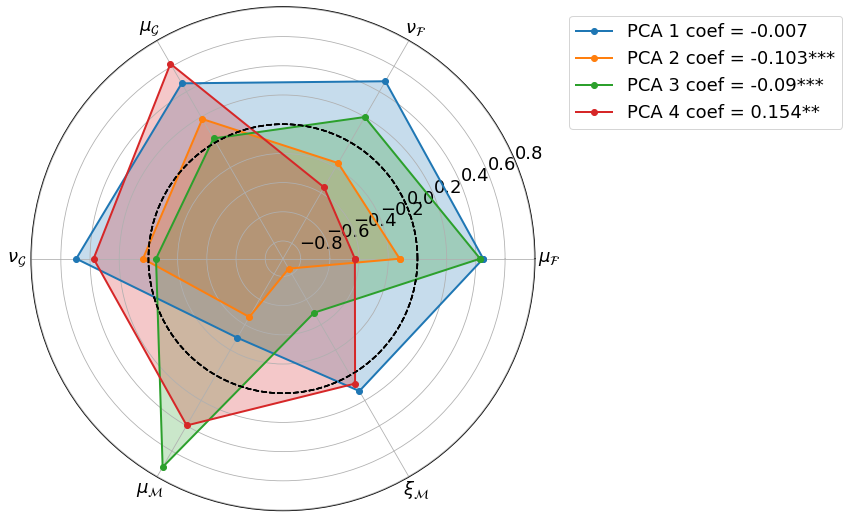

In [19]:
df_radar = pd.DataFrame(pipe['reduce_dims'].components_, columns = reduced_terms_list)
df_radar.loc[:,'coefs'] = pd.Series(extended_model_re_hac.params[[f'pca_{i}' for i in range(n)]].values)
df_radar['pvalues'] = pd.Series(extended_model_re_hac.pvalues[[f'pca_{i}' for i in range(n)]].values)
df_radar.rename(columns = label_dict, inplace=True)

labels =['$\\mu_\\mathcal{F}$',
         '$\\nu_\\mathcal{F}$',
         '$\\mu_\\mathcal{G}$',
         '$\\nu_\\mathcal{G}$',
         '$\\mu_\\mathcal{M}$',
         '$\\xi_\\mathcal{M}$',]

stats_vector = pipe['reduce_dims'].components_[0]

angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
circle_angles = np.linspace(0, 2*np.pi, 1000, endpoint=True)

fig=plt.figure(figsize = (12,12))
ax = fig.add_subplot(111, polar=True)

def convert_pvalue_stars(p):
    if 0.05<p<0.1:
        return "*"
    elif 0.01<p<0.05:
        return "**"
    elif p<=0.01:
        return "***"
    else:
        return ""
        
for i in range(n):
    stats_vector = df_radar.loc[i,labels]
    c = round(df_radar.loc[i,'coefs'], 3)
    p =  round(df_radar.loc[i,'pvalues'], 3)
    ax.plot(np.concatenate((angles,[angles[0]])), np.concatenate((stats_vector,[stats_vector[0]])), 
            'o-', 
            linewidth=2, 
            label = f'''PCA {i+1} coef = {c}{convert_pvalue_stars(p)}'''
    )
    ax.fill(angles, stats_vector, alpha=0.25)
    ax.plot(circle_angles, np.zeros_like(circle_angles), 'k--')
    
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_thetagrids(angles * 180/np.pi, labels)
ax.grid(True)

plt.tight_layout()
save_to = os.path.join(Path(os.getcwd()).parent.resolve(), 'reports', 'figures', f'pca_results.png')
plt.savefig(save_to, transparent=False)    
plt.show()